# Flanker

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [1]:
# !pip install git+https://github.com/lnccbrown/HSSM.git

In [2]:
# necessary imports
from matplotlib import pyplot as plt
import numpy as np
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import pandas as pd
import arviz as az
from scipy.stats import norm
import random

import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


The following code defines two classes, Spotlight_DDM and Spotlight_DDM_with_variable_z, representing variants of the drift diffusion model (DDM), and a plotting function to visualize the simulation results.

**Spotlight_DDM:**

*   This class represents a basic implementation of the drift diffusion model.
*   It simulates the accumulation of evidence over time without any adjustment to the starting point (z) during the simulation.
*   The starting point remains constant throughout the simulation, as specified during initialization.
*   The decision-making process relies solely on the fixed starting point, drift rate, and noise.

**Spotlight_DDM_with_variable_z:**

*   This class extends the basic drift diffusion model by introducing a mechanism to adjust the starting point (z) during the simulation.
*   It allows the starting point to dynamically change based on the decision outcomes during the simulation.
*   When a decision is made (reaching one of the decision thresholds), the starting point is adjusted in the direction of the decision to bias future decisions.
*   This adjustment mechanism can be useful for modeling cognitive processes where decision biases or adjustments occur over time, such as learning or adaptation to changing environments.


The main difference between the two models lies in the treatment of the starting point (z): the basic model keeps it fixed, while the extended model allows it to be adjusted dynamically during simulation based on decision outcomes.

*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

In [3]:
# class for drift diffusion model
class Spotlight_DDM():
    def __init__(self, name):
        self.name = name # to distinguish models properly


    def run(self, v,
                threshold,
                starting_point,
                noise_std,
                non_decision_time,
                dt,
                max_time):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - starting_point: initial condition of the evidence
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = starting_point
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                return time, evidence_over_time, 1  # Decision made for the upper threshold (right)
            elif evidence <= 0:
                return time, evidence_over_time, -1  # Decision made for the lower threshold (left)

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0


class Spotlight_DDM_with_variable_z():
    def __init__(self, name, starting_point: float):
        self.name = name  # to distinguish models properly
        self.starting_point = starting_point
        self.z = starting_point

    def run(self, v, threshold, noise_std, non_decision_time, dt, max_time, increment_step: float = 0):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - v: perceptual input for target flanker (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time
        - increment_step: increment to adjust

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = self.z
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                # Decision made for the upper threshold
                self.adjust_starting_point(1, increment_step)
                return time, evidence_over_time, 1

            elif evidence <= 0:
                # Decision made for the lower threshold
                self.adjust_starting_point(-1, increment_step)
                return time, evidence_over_time, -1

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0

    def adjust_starting_point(self, direction: int, increment: float):
        if (self.z >= self.starting_point and direction == 1) or (self.z <= self.starting_point and direction == -1):
            self.z += increment * direction
            # print(f"Adjusted to {self.z}")
        else:
            self.z = self.starting_point
            # print("Reset to default.")



def plotting(decision_time, evidence_over_time, decision):
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Right" if decision == 1 else "Left" if decision == 0 else "None"})')
    plt.show()
    return



*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


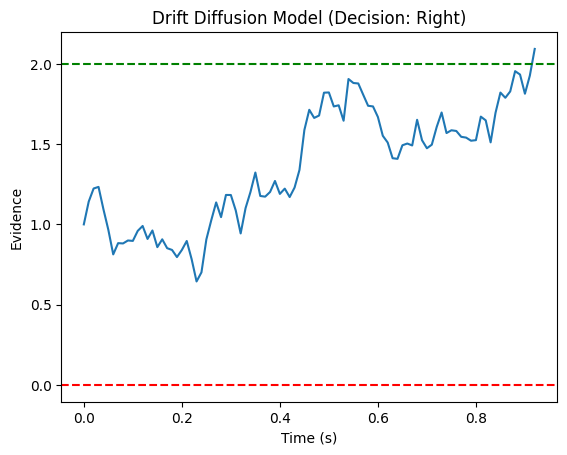

In [4]:
ddm = Spotlight_DDM("my_ddm")
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  starting_point = z,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)
plotting(decision_time, evidence_over_time, decision)


The following code snippet sets parameters for simulating the **Spotlight_DDM_with_variable_z** and then visualizes the evidence accumulation process.

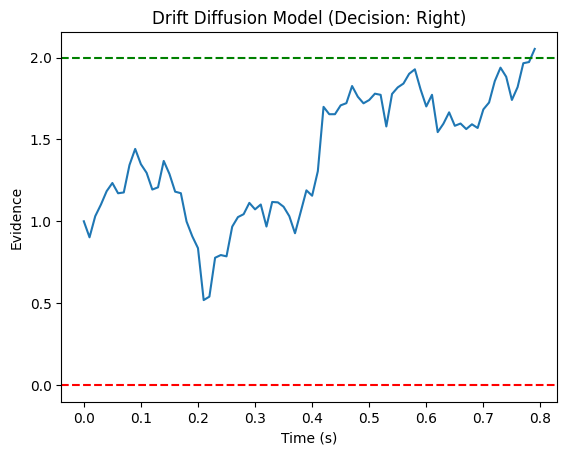

In [5]:
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
increment = 0.1   # directional increment for adjusting the z-param
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

ddm = Spotlight_DDM_with_variable_z("my_variable_ddm", starting_point = z)

decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

plotting(decision_time, evidence_over_time, decision)

*We still need some text here.*

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



This code snippet conducts Bayesian inference through Markov Chain Monte Carlo (MCMC) sampling for two drift diffusion models. The process involves executing Bayesian inference for both models using the NUTS (No-U-Turn Sampler) algorithm implemented in NumPyro. Configurations for the sampling process include parameters like the number of chains, draws, tune steps, and the type of data used for model comparison.

In [6]:
# using MCMC sampling
# 1) load the data
data = pd.read_csv("../data/subject_3029.csv", delimiter = ";")
data.head()

# 2) prepare the models

varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_ddm_model = hssm.HSSM(
    data = data,
)


# 3) fit both models using mcmc sampling
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Compilation time = 0:00:01.665143
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.793076
Transforming variables...
Transformation time = 0:00:00.054033
Computing Log Likelihood...
Log Likelihood time = 0:00:00.417502
Compiling...
Compilation time = 0:00:01.595465
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.596808
Transforming variables...
Transformation time = 0:00:00.041702
Computing Log Likelihood...
Log Likelihood time = 0:00:00.373843


In [7]:
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

In [8]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
basic,0,-1378.463282,0.035175,0.000000,1.000000e+00,0.016374,0.000000,False,log
varying starting point,1,-3158.996231,2704.708099,1780.532949,1.107878e-10,0.004968,0.014155,True,log


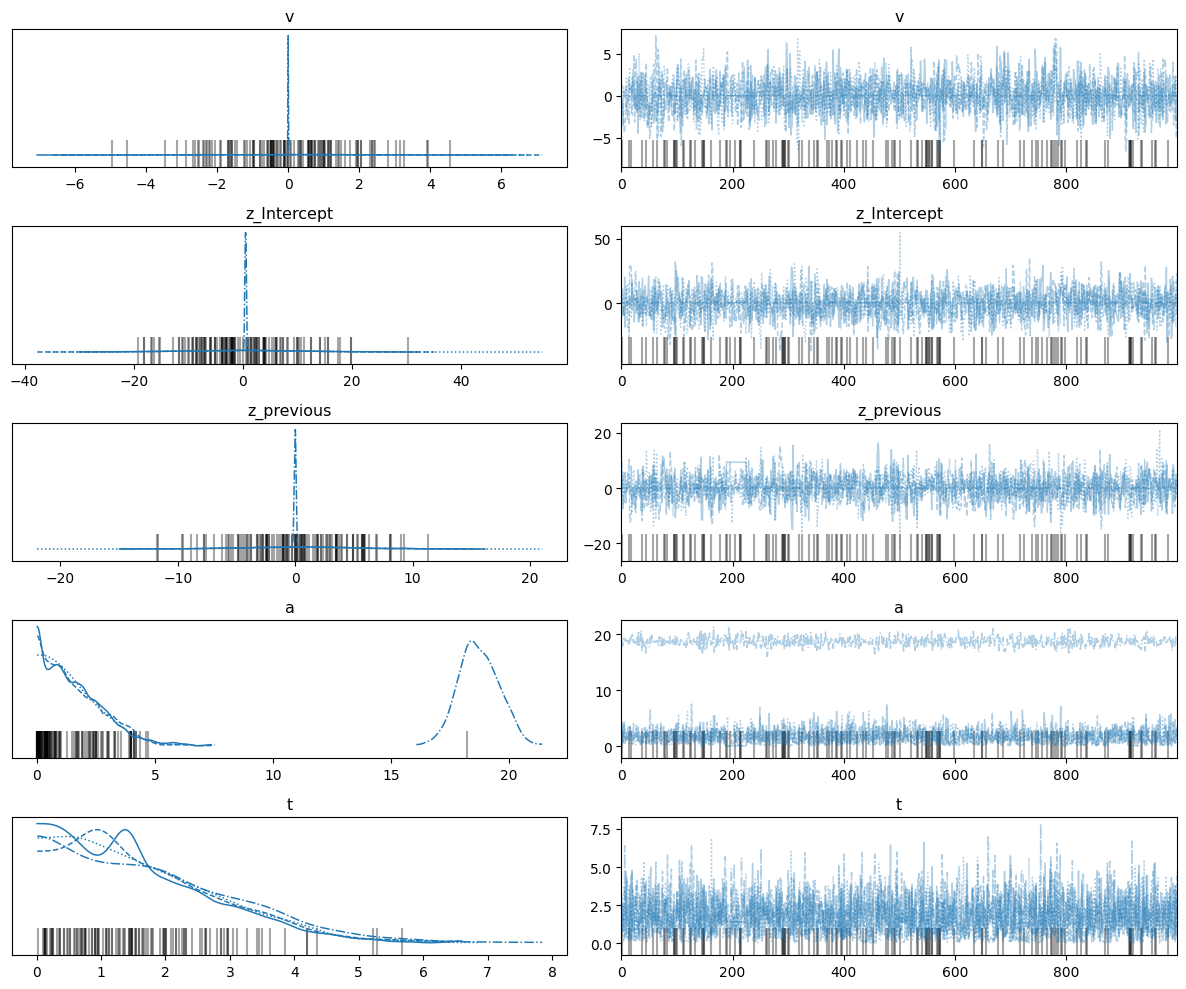

In [9]:
varying_starting_point_model.plot_trace()

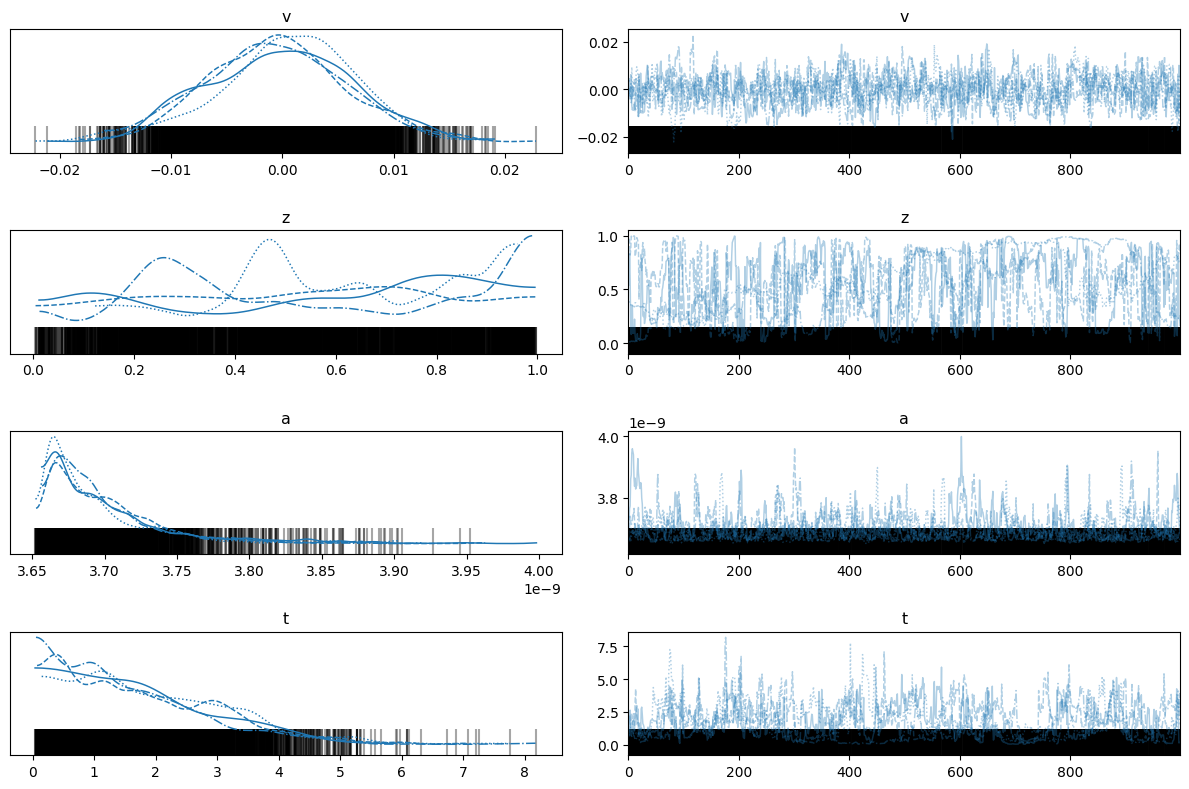

In [10]:
basic_ddm_model.plot_trace()

Compiling...
Compilation time = 0:00:01.571078
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.959315
Transforming variables...
Transformation time = 0:00:00.037301
Computing Log Likelihood...
Log Likelihood time = 0:00:00.795551
Compiling...
Compilation time = 0:00:01.767926
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.960890
Transforming variables...
Transformation time = 0:00:00.066091
Computing Log Likelihood...
Log Likelihood time = 0:00:00.756790


                        rank      elpd_loo       p_loo  elpd_diff  weight  \
basic                      0 -82634.200195   51.527344    0.00000     1.0   
varying starting point     1 -82983.164505  139.370209  348.96431     0.0   

                              se       dse  warning scale  
basic                   4.605547  0.000000     True   log  
varying starting point  0.431255  4.619991     True   log  


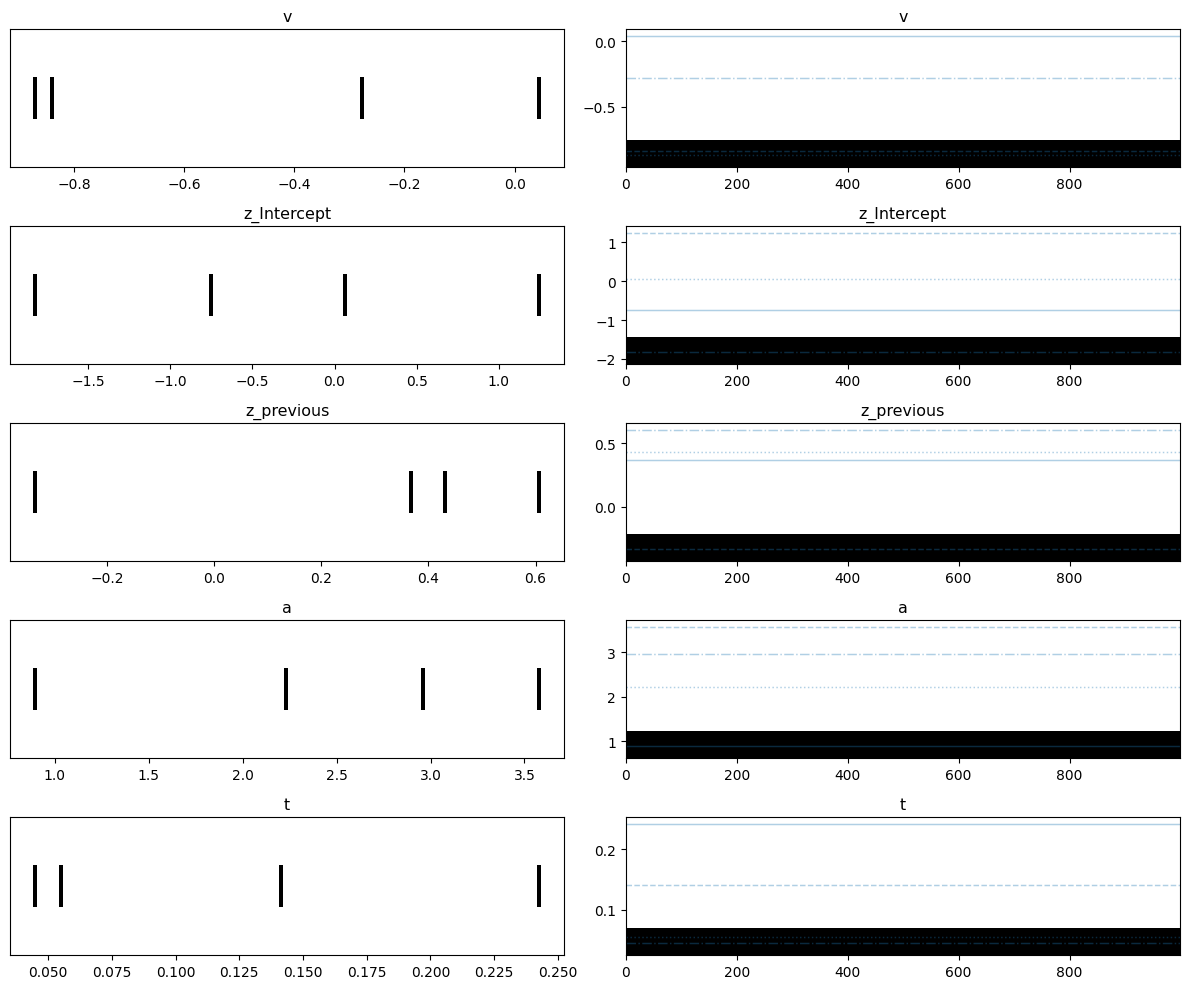

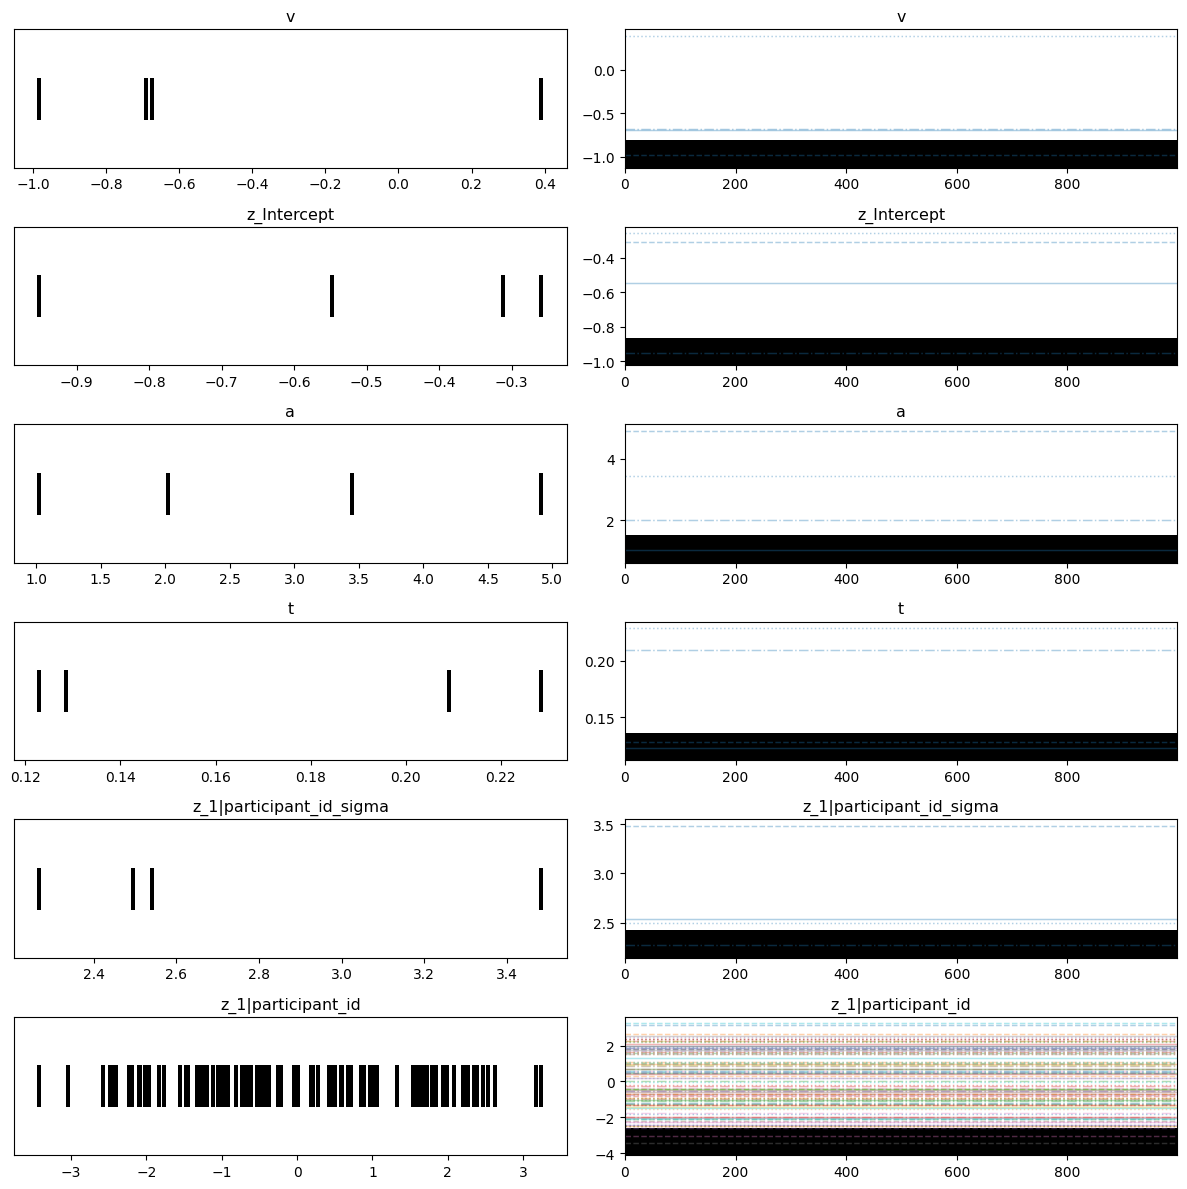

In [11]:
official_data = pd.read_csv("../data/data.csv", delimiter = ",")

# make StimVar the response column and switch values everywhere, where there is a 0 in Response
falsies = np.where(official_data["Response"] == 0)[0]

for index in range(len(falsies)):
    official_data.at[falsies[index], "StimVar"] = 1 if official_data.at[falsies[index], "StimVar"] == 2 else 2

official_data['previous'] = official_data.loc[:, 'StimVar']
official_data['previous'] = official_data['StimVar'].shift(1)
official_data = official_data.drop(['Response', 'Condition', 'Onset', 'Block'], axis = 1)
official_data = official_data.rename(columns={"SubjectID": "participant_id", "StimVar": "response", "RT": "rt"})
official_data["response"] = np.where(official_data["response"] == 2, 1, -1)
official_data.at[0, 'previous'] = 0
official_data['previous'] = official_data['previous'].astype('int')

varying_starting_point_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ (1|participant_id)",
        }
    ],
)

# 3) fit both models using mcmc sampling
varying_starting_point_model_on_official_data_inference = varying_starting_point_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_model_on_official_data_inference = basic_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model_on_official_data.traces,
        "basic": basic_model_on_official_data.traces,
    }
)
print(model_comparison)

varying_starting_point_model_on_official_data.plot_trace()
basic_model_on_official_data.plot_trace()

In [12]:
v = 0.5             # drift rate
a = 2.0             # threshold
z = 1.0             # starting point (between 0 and threshold a)
t0 = 0.2            # non-decision time

true_values = [v, a, z, t0]

hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

hssm_dataset

,rt,response
0,0.200885,1.0
1,0.201064,1.0
2,0.200594,1.0
3,0.204298,1.0
4,0.201134,1.0
...,...,...
495,0.207617,1.0
496,0.201368,1.0
497,0.202532,1.0
498,0.200937,1.0


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [13]:
# summary plots

def parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as):
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))  # Adjust the figsize as needed

    # Create the first scatter plot on the left
    ax1.scatter(true_ts, recovered_ts, marker='o', color='red')
    ax1.set_xlabel('True t')
    ax1.set_ylabel('Fitted t')
    ax1.set_title('Recovery of t')

    # Create the second scatter plot on the right
    ax2.scatter(true_vs, recovered_vs, marker='o', color='red')
    ax2.set_xlabel('True v')
    ax2.set_ylabel('Fitted v')
    ax2.set_title('Recovery of v')

    # Create the second scatter plot on the right
    ax3.scatter(true_zs, recovered_zs, marker='o', color='red')
    ax3.set_xlabel('True z')
    ax3.set_ylabel('Fitted z')
    ax3.set_title('Recovery of z')

    ax4.scatter(true_as, recovered_as, marker='o', color='red')
    ax4.set_xlabel('True a')
    ax4.set_ylabel('Fitted a')
    ax4.set_title('Recovery of a')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Compute the Pearson correlation coefficient for t
    correlation_matrix = np.corrcoef(true_ts, recovered_ts)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for t: {correlation}")

    # Compute the Pearson correlation coefficient for v
    correlation_matrix = np.corrcoef(true_vs, recovered_vs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for v: {correlation}")

    # Compute the Pearson correlation coefficient for z
    correlation_matrix = np.corrcoef(true_zs, recovered_zs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for z: {correlation}")

    # Compute the Pearson correlation coefficient for a
    correlation_matrix = np.corrcoef(true_as, recovered_as)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for a: {correlation}")

Compiling...


0.13436424411240122
0.6948674738744653
0.5904711216198447
2.3149463950321807


Compilation time = 0:00:00.918842
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:08.608558
Transforming variables...
Transformation time = 0:00:00.057334
Computing Log Likelihood...
Log Likelihood time = 0:00:00.494384
Compiling...


0.49543508709194095
-0.10101787042252375
1.5692594548780723
1.9896196208960126


Compilation time = 0:00:01.470032
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:39.928732
Transforming variables...
Transformation time = 0:00:00.041882
Computing Log Likelihood...
Log Likelihood time = 0:00:00.501173
Compiling...


0.0938595867742349
-0.9433050469559874
1.0921823858847217
2.523718801367622


Compilation time = 0:00:01.449566
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:04.821719
Transforming variables...
Transformation time = 0:00:00.042071
Computing Log Likelihood...
Log Likelihood time = 0:00:00.493582
Compiling...


0.762280082457942
-0.9957878932977786
1.0041116054012467
1.3916228627589242


Compilation time = 0:00:01.485657
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:39.804664
Transforming variables...
Transformation time = 0:00:00.041974
Computing Log Likelihood...
Log Likelihood time = 0:00:00.776516
Compiling...


0.22876222127045265
0.8905413911078446
0.08302548514286764
2.7141396270733025


Compilation time = 0:00:00.934862
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.590926
Transforming variables...
Transformation time = 0:00:00.041745
Computing Log Likelihood...
Log Likelihood time = 0:00:00.452223
Compiling...


0.0254458609934608
0.08282494558699316
1.076342581719086
2.8235325720576805


Compilation time = 0:00:01.208321
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.541332
Transforming variables...
Transformation time = 0:00:00.041447
Computing Log Likelihood...
Log Likelihood time = 0:00:00.481410
Compiling...


0.21659939713061338
-0.15576684883456537
0.04083965833062931
0.18421828396711704


Compilation time = 0:00:00.918854
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:41.181226
Transforming variables...
Transformation time = 0:00:00.042743
Computing Log Likelihood...
Log Likelihood time = 0:00:00.434463
Compiling...


0.43788759365057206
-0.008375517236298702
0.17913971681614582
0.7759449057469606


Compilation time = 0:00:00.924280
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.287404
Transforming variables...
Transformation time = 0:00:00.044490
Computing Log Likelihood...
Log Likelihood time = 0:00:00.435641
Compiling...


0.2187810373376886
-0.08079306852453283
0.020208202844774214
0.940366682312408


Compilation time = 0:00:00.920307
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:17.222137
Transforming variables...
Transformation time = 0:00:00.041002
Computing Log Likelihood...
Log Likelihood time = 0:00:00.428212
Compiling...


0.8375779756625729
0.11290864530486688
0.36486961178166466
1.9626536525040923


Compilation time = 0:00:00.908799
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.179090
Transforming variables...
Transformation time = 0:00:00.040634
Computing Log Likelihood...
Log Likelihood time = 0:00:00.447141
Compiling...


0.9925434121760651
0.7198930575905798
0.14990609053474974
0.45058088343683855


Compilation time = 0:00:00.929687
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:12.557073
Transforming variables...
Transformation time = 0:00:00.395550
Computing Log Likelihood...
Log Likelihood time = 0:00:00.435782
Compiling...


0.7214844075832684
0.4223835393905593
1.1885172675306204
2.815677701718433


Compilation time = 0:00:01.185339
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:39.652157
Transforming variables...
Transformation time = 0:00:00.041384
Computing Log Likelihood...
Log Likelihood time = 0:00:00.480295
Compiling...


0.830035693274327
0.34061113282814204
0.5756930758769709
0.979768681705461


Compilation time = 0:00:00.933680
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.082661
Transforming variables...
Transformation time = 0:00:00.041014
Computing Log Likelihood...
Log Likelihood time = 0:00:00.432668
Compiling...


0.8824790008318577
0.6923948368566255
0.9219788284042172
1.5653230796808413


Compilation time = 0:00:01.331763
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:13.193046
Transforming variables...
Transformation time = 0:00:00.041005
Computing Log Likelihood...
Log Likelihood time = 0:00:00.436372
Compiling...


0.034525830151341586
-0.5145200529138647
0.9995210542346563
2.4124723179074783


Compilation time = 0:00:01.334468
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.377484
Transforming variables...
Transformation time = 0:00:00.041044
Computing Log Likelihood...
Log Likelihood time = 0:00:00.437635
Compiling...


0.17300740157905092
0.09759752277630596
1.4426025766588297
2.1388182099903315


Compilation time = 0:00:01.614036
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:02.929754
Transforming variables...
Transformation time = 0:00:00.041620
Computing Log Likelihood...
Log Likelihood time = 0:00:00.482498
Compiling...


0.3747030205016403
-0.12207673991087375
1.2256087121411192
1.5744368159249473


Compilation time = 0:00:01.608928
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:35.558150
Transforming variables...
Transformation time = 0:00:00.042463
Computing Log Likelihood...
Log Likelihood time = 0:00:00.484090
Compiling...


0.5209384176131452
-0.21348981007154788
0.04495723424193825
1.5201112093405489


Compilation time = 0:00:00.912492
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:12.608569
Transforming variables...
Transformation time = 0:00:00.040857
Computing Log Likelihood...
Log Likelihood time = 0:00:00.435770
Compiling...


0.04348729035652743
0.406764177207672
1.7506301507090627
2.9512443801980544


Compilation time = 0:00:01.192536
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.235286
Transforming variables...
Transformation time = 0:00:00.040696
Computing Log Likelihood...
Log Likelihood time = 0:00:00.936558
Compiling...


0.393599686377914
-0.6593016062886374
1.528594252408665
1.556491819457101


Compilation time = 0:00:01.189065
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:30.380261
Transforming variables...
Transformation time = 0:00:00.041232
Computing Log Likelihood...
Log Likelihood time = 0:00:00.480477


Pearson correlation coefficient for t: -0.5801676745416287
Pearson correlation coefficient for v: -0.4305850764942285
Pearson correlation coefficient for z: 0.7563680378990507
Pearson correlation coefficient for a: -0.3998662596095586


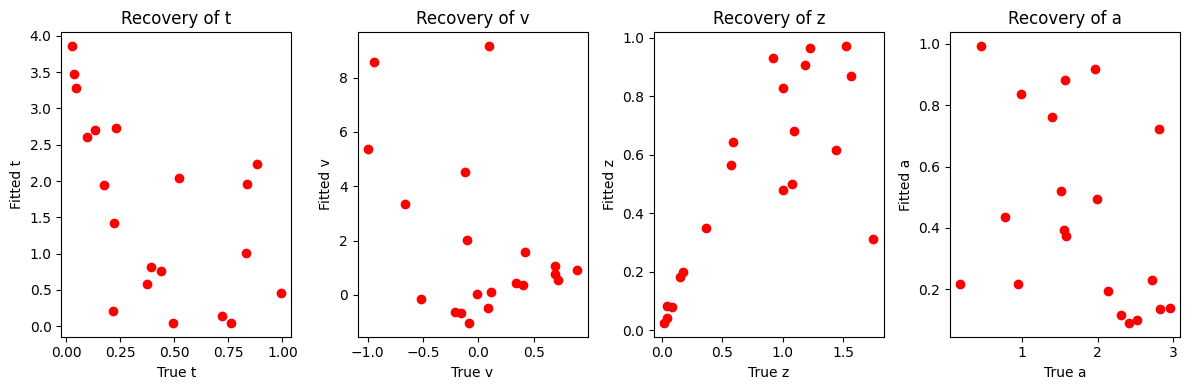

In [14]:
random.seed(1)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

num_samples = 20

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)


for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as)]:
      log[index] = value
      print(str(value))

    # simulate
    true_values = [true_v, true_a, true_z, true_t]

    hssm_dataset = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=500,
    )

    simulation_model = hssm.HSSM(
        data=hssm_dataset,
        model="ddm",
    )

    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
                        # the number of CPU cores used to run MCMC sampling
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]


parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)








In [15]:
def simulate_increment_model(num_simulations, model, t, v, a, increment):
    log = []
    for run in range(num_simulations):
        decision_time, evidence, decision = model.run(v = v,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = 1,
                                                  non_decision_time = t,
                                                  dt = 0.01,
                                                  max_time = 1000)
        log.append({"rt": decision_time, "response": decision})
    return pd.DataFrame(log)


Compiling...


0.9560342718892494
0.8956549741186988
0.022406118998918468
0.26399896640774523
0.16726427674776048


Compilation time = 0:00:01.674246
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:49.789133
Transforming variables...
Transformation time = 0:00:00.041821
Computing Log Likelihood...
Log Likelihood time = 0:00:00.467026
Compiling...


0.7359699890685233
0.3394608028804418
0.6020635338238619
0.9935957270085182
0.12175354499452674


Compilation time = 0:00:01.695571
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:56.365800
Transforming variables...
Transformation time = 0:00:00.050006
Computing Log Likelihood...
Log Likelihood time = 0:00:00.484000
Compiling...


0.5812040171120031
-0.6832342594903889
0.5308515836284822
1.3489419568446792
0.14487940416625572


Compilation time = 0:00:01.464719
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:43.509596
Transforming variables...
Transformation time = 0:00:00.041016
Computing Log Likelihood...
Log Likelihood time = 0:00:00.434922
Compiling...


0.9948195629497427
0.8987909461864871
0.7465157918490478
1.6781134375450304
0.05437990758821629


Compilation time = 0:00:01.205136
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:44.536712
Transforming variables...
Transformation time = 0:00:00.041807
Computing Log Likelihood...
Log Likelihood time = 0:00:01.009239
Compiling...


0.03592432939285761
-0.945110285818362
0.4611987141558779
1.4481922000822052
0.07662296945824162


Compilation time = 0:00:01.183150
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.263920
Transforming variables...
Transformation time = 0:00:00.042770
Computing Log Likelihood...
Log Likelihood time = 0:00:00.466321
Compiling...


0.8917894578282874
0.05150553829205662
0.40742622760123043
1.7254800469768468
0.005747757749015657


Compilation time = 0:00:01.514992
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.977931
Transforming variables...
Transformation time = 0:00:00.041828
Computing Log Likelihood...
Log Likelihood time = 0:00:00.450867
Compiling...


0.32514292876116
-0.7266052140270667
1.5775696525383607
1.5796491529278833
0.13522145977182815


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float32, shape=(500,)) (of Variable Alloc.0) into Type Vector(bool, shape=(500,)). You can try to manually convert Alloc.0 into a Vector(bool, shape=(500,)). local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): node: Composite{...}([0.3351429 ... .33514294], ExpandDims{axis=0}.0, [0.5], Composite{sqr((-i0))}.0, ExpandDims{axis=0}.0, [3.1415927e-15], [1.e-15], [6.2831855], [0.31830987], [1])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/home/max/miniconda3/envs/flanker/lib/python3.10/site-packages/pytensor/

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:56.400917
Transforming variables...
Transformation time = 0:00:00.042482
Computing Log Likelihood...
Log Likelihood time = 0:00:00.496518
Compiling...


0.18184349682314438
0.787143073165977
1.770351488732956
2.4106037721227547
0.18141213632961464


Compilation time = 0:00:01.252793
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:02:00.616071
Transforming variables...
Transformation time = 0:00:00.043694
Computing Log Likelihood...
Log Likelihood time = 0:00:00.494685
Compiling...


0.762885483833071
0.5794952749235265
1.1045621949569544
1.1259822357406502
0.19241828664174693


Compilation time = 0:00:01.892203
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:58.795676
Transforming variables...
Transformation time = 0:00:00.042747
Computing Log Likelihood...
Log Likelihood time = 0:00:00.497583
Compiling...


0.16118465330401888
0.5080081433037442
1.00306937136876
2.173937604888615
0.10654078750856556


Compilation time = 0:00:01.643765
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:37.697350
Transforming variables...
Transformation time = 0:00:00.042714
Computing Log Likelihood...
Log Likelihood time = 0:00:00.441625


Pearson correlation coefficient for t: -0.6063363745228936
Pearson correlation coefficient for v: 0.12415595692630557
Pearson correlation coefficient for z: 0.6663297258722845
Pearson correlation coefficient for a: -0.599193045539941


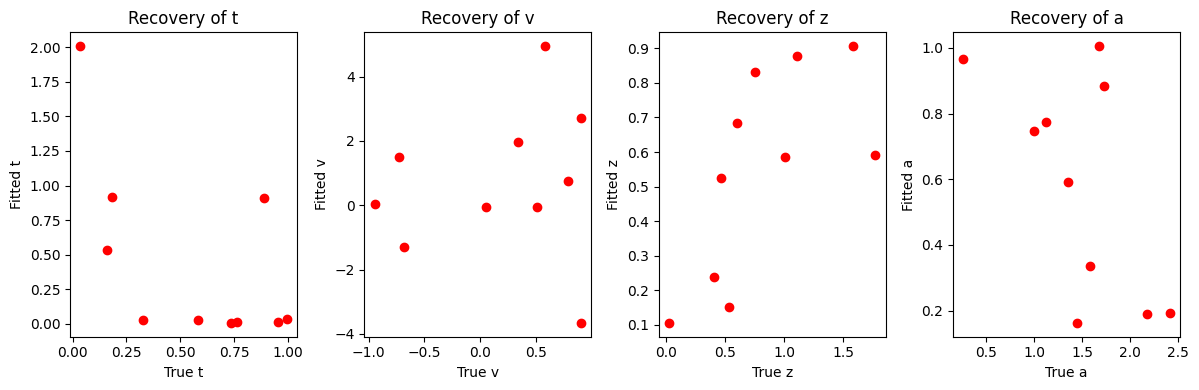

In [16]:
random.seed(2)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

# increment step
min_in = 0.001
max_in = 0.2

num_samples = 10

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)
true_ins = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)





for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a
    true_increment = random.uniform(min_in, max_in)

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as), (true_increment, true_ins)]:
      log[index] = value
      print(str(value))

    surrogate_model = Spotlight_DDM_with_variable_z(name = "simulation_model", starting_point = true_z)

    surrogate_data = simulate_increment_model(500, surrogate_model, true_t, true_v, true_a, true_increment)

    simulation_model = hssm.HSSM(
        data=surrogate_data,
        model="ddm",
    )

    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
                        # the number of CPU cores used to run MCMC sampling
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]


parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [17]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [18]:
# Loading the experimental data
data = pd.read_csv("../data/data.csv", delimiter=",")

basic_model = Spotlight_DDM("BasicDDM_data")


# Fit Standard model
basic_ddm_model = hssm.HSSM(
    data = data,
)

basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)



# Fit Model with varying z-value
varying_starting_point_model = Spotlight_DDM_with_variable_z("VaryingZ_DDM_data", starting_point=1)

varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
                    # this is the number of CPU cores used to run MCMC sampling
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

KeyError: 'response'